In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import utils as u
from IPython.core.display import HTML

$$
\newcommand{P}[1]{\mathrm{P}\left( #1 \right)}
\newcommand{Pc}[2]{\mathrm{P}\left( #1 \mid #2 \right)}
$$

[Simpson' Paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox) is a example of one of the counter intuitive properties of probability distributions. It occurs when an observed relationship between two variables is reversed when you take into account another variable. 

The paradox itself has been [described](http://michaelnielsen.org/reinventing_explanation/) [very](http://vudlab.com/simpsons/) [well](http://ftp.cs.ucla.edu/pub/stat_ser/r414.pdf) [elsewhere](http://andrewgelman.com/2014/04/08/understanding-simpsons-paradox-using-graph/), so I'm not going to describe it in too much detail here. Instead I'm going to try and ask another question: how do we write a program to generate examples of Simpson's paradox?

Before getting into it, let's start with an example of the paradox:

Imagine we are trying to work out whether a certain drug is an effective treatment for a disease. To decide whether it is effective, we look at what fraction of people took the drug (call this $x$, if someone took the drug, $x=1$, if not $x=0$), compared with what fraction recovered (call this $y$ - $y=1$ mean they got better, $y=0$ mean they did not). 

When we just look at these two numbers, we find that of 250 people who took the drug, 110 recovered, whereas out of the 250 people who did not take the drug 177 recovered. From these results it looks like there is a clear advantage to not taking the drug. Unfortunately, this drug was not administered as part of a [random controlled trial](https://en.wikipedia.org/wiki/Randomized_controlled_trial). This means that the decision of whether or not to take the drug may have been [confounded](https://en.wikipedia.org/wiki/Confounding).

In fact, if we look at the recovery rate for different age groups (denoted by variable $z$), we find that for each age group more of those who took the drug recovered than those who did not, as shown in the table below

In [2]:
HTML(u.create_table(pd.read_csv("binary_example.csv")))

So, how can we generate examples of the paradox? let's start by defining it precisely.

## Binary Case

Consider the situation where we have three random variables, two binary: $x$, $y$ and one discrete, $z$. Simpson's paradox is observed if when considering just the $x$ and $y$ variables, there appears to be a negative correlation between $x=1$ and $y = 1$. 

Specifically

$\Pc{Y=1}{X=1} < \Pc{Y=1}{X=0}$

but when we look at each subgroup, the relationship is the other way round:

$\Pc{Y=1}{X=1, Z=i} > \Pc{Y=1}{X=0, Z=i}$

For all $i$. 

To find a distribution which obeys these inequalities, let's start by parameterising it by:

$\Pc{Y=1}{X, Z} = p_{X,Z}$

And 

$\Pc{Z}{X} = q_{X,Z}$

The marginal distribution can be written as

$\Pc{Y=1}{X=j} = \sum_{i\in Z} \Pc{Y=1}{X=j, Z=i} \Pc{Z=i}{X=j} = \sum_{i\in Z} p_{j,i}q_{j,i}$

So we are looking for $p$ and $q$ which obey

$p_{1,i} > p_{0,i}$

$\sum_{i\in Z} p_{1,i}q_{1,i} < \sum_{i\in Z} p_{0,i}q_{0,i}$

$\sum_{i\in Z} q_{j,i} = 1$

I will also choose the labels so that:

$p_{j,i} < p_{j,k}$

if $i < k$. 

Before we look for a solution, let's write a function which takes descriptions $p$ and $q$ and checks whether they obey this inequality: 

In [3]:
def assert_paradox_binary_distribution(p, q):
    """
    Asserts whether a distribution described by p,q demonstrates 
    Simpson's paradox. 
    
    :param p: dictionary, p[x][z] = p(Y=1|X,Z)
    :param q: dictionary, q[x][z] = p(Z|X)
    :return: None
    """
    n_samples = len(p[0])
    for i in range(n_samples):
        assert(p[0][i] < p[1][i])
            
    assert(all(0 < qq < 1 for qq in q[1].values()))
    assert(all(0 < qq < 1 for qq in q[0].values()))
    
    b0 = sum(p[0][i] * q[0][i] for i in range(n_samples))
    b1 = sum(p[1][i] * q[1][i] for i in range(n_samples))
    
    assert(b0 > b1)

To generate a solution, note that the terms $\sum_{i\in Z} p_{j,i}q_{j,i}$ generate a convex combination of the $p$ values. Given a free choice of $q$, we can make this term lie anywhere between the largest and smallest $p_{j,i}$ value. To meet the second inequality, we require that  

$p_{1,0} < p_{0,n}$

Where $n$ is the largest value $Z$ can take.

We now have the ingredients to a solution. We can put them together in the following way:
 1. Choose $p$ values so that $p_{1,i} > p_{0,i}$ for all $i$ and $p_{1,0} < p_{0,n}$
 2. Choose two values in the region $(p_{1,0}, p_{0,n})$, $b_{1}$ and $b_{0}$ so that $b_{1}$ < $b_{0}$
 3. Find $q$'s so that $\sum_{i\in Z} p_{j,i}q_{j,i} = b_{j}$
 

Programmatically, we can carry out the the first step with the following function

In [4]:
from collections import defaultdict

def generate_p_values(n_subgroups):
    """
    Generates a set of conditional probabilities that obey
    
     - p(Y=1|x=1, z) > p(Y=1|x=0, z) for all z
     - p(Y=1|x=1, z=j) > p(Y=1|x=1, k) when j > k
     - p(Y=1|x=1, z=0) < p(Y=1|x=0, z=n) where n = max(z)
     
    :param n_subgroups: int. The number of values $Z$ can take.
    :return: dictionary, p[x][z] = p(Y=1|x,z)
    """
    p = defaultdict(dict)

    boundaries = np.random.uniform(0, 1, size=2 * n_subgroups)
    boundaries = [(n + b) / (2*n_subgroups) for n, b in enumerate(boundaries)]

    for i in range(n_subgroups):
        p[0][i] = boundaries[i*2]
        p[1][i] = boundaries[i*2+1]

    return p

Which generates a solution to the inequalities by generating a set of ordered random numbers between (0,1) and assigning them to $p_{i,j}$ ordered by ($i$, $j$). The method we use to generate the random numbers ensure they are spread across the whole range.

We now need a function which for a given set of $p$'s, and a target values, find the weights which obeys

$\sum_{i} p_{i}q_{i} = target$

$\sum_{i} q_{i} = 1$

When there are only two subgroups, this has an exact solution. When there are more, there are a number of solutions. 

The following function does this

In [5]:
def get_q_weights(ps, target):
    """
    Generates a mixture of the values in ps which is the solution to
    
    \sum_{i} p[i]q[i] = target
    
    :param ps: list of number
    :param target: goal of the sum
    :return: qs: list of weightings of ps
    """
    if len(ps) <= 1:
        raise ValueError("ps cannot be shorter than 2")

    if len(ps) == 2:
        p0, p1 = ps
        q0 = (p1 - target) / (p1 - p0)
        return q0, (1 - q0)

    rest, last = ps[:-1], ps[-1]
    mid_target = np.random.uniform(low=rest[0], high=min(target, rest[-1]))

    q0, q1 = get_q_weights([mid_target, last], target)
    remaining_qs = get_q_weights(rest, mid_target)
    qs = [q0 * q for q in remaining_qs] + [q1]

    return qs

With these two functions, we can generate the compete distribution and check that it meets our original requirements

In [6]:
def generate_paradox_binary_distribution(n_subgroups=3):
    """
    Generates a distribution which demonstrates Simpson's paradox 
    
    q[x][z] = p(Z|X)
    p[x][z] = p(Y=1|X,Z)
    
    :param n_subgroups: int
    :return: p, q: dicts
    """

    p = generate_p_values(n_subgroups)
    
    p_low, p_high= p[1][0], p[0][n_subgroups-1]

    b1, b0 = np.random.uniform(size=2)
    b1, b0 = p_low+((1+b1)/5)*(p_high-p_low), p_low+((3+b0)/5)*(p_high-p_low) 
    
    
    q = {}
    q[0] = {k: v for k, v in enumerate(get_q_weights(sorted(p[0].values()), b0))}
    q[1] = {k: v for k, v in enumerate(get_q_weights(sorted(p[1].values()), b1))}

    return p, q

p, q = generate_paradox_binary_distribution(4)

assert_paradox_binary_distribution(p, q)

We have generated a distribution which violates Simpson's paradox. Now let's draw some samples from it. 

It is worth noting that up until this point we haven't talked about how the $X$ values are distributed. It is because they don't matter for the current discussion. As long as there is some variability in the outcome, we can demonstrate the paradox. However, now that we want to actually generate counts we do need to specify it.

In [7]:
def realise_binary_paradox(p, q, x, n_approx_samples=100):
    """
    Realises the mean outcome from the provided distribution
    :param p: dict, p[x][z] = p(Y=1|X,Z)
    :param q: dict, q[x][z] = p(Z|X)
    :param x: dict, x[i] = p(x)
    :param n_approx_samples: int
    :return: Dataframe of outcomes
    """
    records = []
    for xx in x.keys():
        for zz in q[xx].keys():
            p_y_eq_0 = x[xx] * q[xx][zz] * (1 - p[xx][zz])
            p_y_eq_1 = x[xx] * q[xx][zz] * p[xx][zz]
            records.append({"x": xx, "z": zz, "y": 1, 
                            "count": round(n_approx_samples * p_y_eq_1)})
            records.append({"x": xx, "z": zz, "y": 0, 
                            "count": round(n_approx_samples * p_y_eq_0)})
    return pd.DataFrame.from_records(records)

Because this function involves rounding the number of samples to integers, it is possible for some groups to end up with equal ratios, however on average it does produce the required paradox. 

Let's take a look at the outcome

In [8]:
p, q = generate_paradox_binary_distribution(n_subgroups=3)
x = {0:0.3, 1:0.7}

df = realise_binary_paradox(p, q, x, n_approx_samples=500)

HTML(u.create_table(df))

# Continuous Example  

It is possible to generate examples of Simpson's paradox for continuous variables. The simplest example would be look at the [Covariance](https://en.wikipedia.org/wiki/Covariance) between two variables, $x$ and $y$, which is one sign for a collection of subgroups, but a different sign for the whole population.

If we consider the variables $x$ and $y$ as being drawn from the [mixture distribution](https://en.wikipedia.org/wiki/Mixture_distribution) then by the [law of total covariance](https://en.wikipedia.org/wiki/Law_of_total_covariance), the covariance of the total population is given by two components:
 - a weighted sum of the subpopulation covariances 
 - the covariance of the subpopulation means
 
If the sign of the covariance for the subpopulations are all in one direction, the first term will be in that direction. If the overall population is going to be the opposite sign, it needs to be compensated by the second term. 

Using multivariate normal distributions, this is straightforward to simulate:

In [9]:
def generate_gaussian_simpsons_paradox(n_subgroups=3, n_samples=1000):

    overall_cov = 3*np.array([[1,0.9], [0.9,1]])

    means = np.random.multivariate_normal(mean=[0,0], cov=overall_cov, size=n_subgroups)
    
    weights = np.random.uniform(size=n_subgroups)
    weights /= np.sum(weights)
    covs = [np.random.uniform(0.2,0.8) for _ in range(n_subgroups)]
    covs = [np.array([[1,-c], [-c,1]]) for c in covs]


    samples = []

    for sg, (mean, cov, w) in enumerate(zip(means, covs, weights)):
        n = int(round(n_samples * w))
        sample = np.random.multivariate_normal(mean=mean, cov=cov, size=n)
        sample = pd.DataFrame(sample, columns=["x", "y"])
        sample["z"] = sg
        samples.append(sample)
        
    df = pd.concat(samples)
    
    return df

Because we are generating the means and covariances randomly, it is possible to end up with a sample which does not demonstrate the paradox, but on average it will.

In [10]:
df = generate_gaussian_simpsons_paradox()

print("Total Covariance: {:.3f}".format(df[["x", "y"]].cov().iloc[0,1]))
for z in df.z.unique():
    print("Subgroup {} covariance: {:.3f}".format(z,df[df.z==z][["x", "y"]].cov().iloc[0,1]))


Total Covariance: 0.121
Subgroup 0 covariance: -0.466
Subgroup 1 covariance: -0.678
Subgroup 2 covariance: -0.282


This is clearer if we plot what's going on. 

For the overall population, there is a positive correlation between $x$ and $y$:

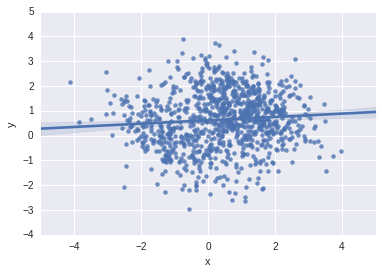

In [11]:
sns.regplot(data=df, x="x", y="y");

But for each subpopulation, the correlation is negative

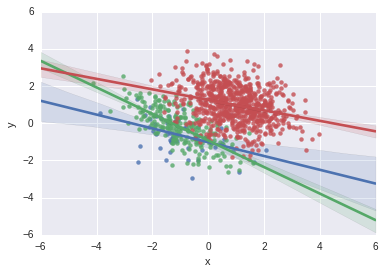

In [12]:
fig, ax = plt.subplots()

plt.xlim(-6,6);
plt.ylim(-6,6);

for z in df.z.unique():
    sns.regplot(data=df[df.z==z], x="x", y="y", ax=ax)

# Code

You can find the notebook for this post on github [here]().